# Exercício Proposto 1 - Método Numéricos (PEC00141)

---

[1.Dados](#section_1)

[2.Inserindo os dados](#section_2)

[3.Plotagem da estrutura](#section_3)

[4.Comprimento das barras e cos e sen diretores](#section_4)

[5.Montagem da matriz de rigidez](#section_5)

[6.Aplicação das condições de contorno](#section_6)

[6.1 Montagem do vetor de forças](#section_6.1)

[7.Resolução da equação de equilíbrio](#section_7)

[8.Plotagem da treliça deformada](#section_8)

[9.Determinação dos esforços](#section_9)

---

`Créditos ao minicurso do CEMACOM`:https://www.youtube.com/watch?v=0lo3t2k4zLI&list=PLMAtwHzjmH0APh2PbWldGniwGccPdn5u9&ab_channel=CEMACOM

## 1. Dados <a name="section_1"></a>
Para a treliça ilustrada na figura abaixo:
<img src="imagem.jpg" style="width:400px;height:400px"/>

1. montar a matriz de rigidez global;
2. montar o vetor de cargas;
3. introduzir as condições de contorno;
4. calcular os deslocamentos. 

Considerar que todas as barras são feitas de material com $E = 2x10^{8} kN/m^{2}$ e as barras têm
seções transversais com áreas: $A1=A2=0,01m^{2}$, $A3=A4=A5=0,015m^{2}$. Notar que o **apoio 2 sofre um cedimento de 0,03m**.

## 2. Inserindo os dados <a name="section_2"></a>

Importação de módulos que serão utilizados

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

`!!!`
Há 5 barras de treliça plana, 4 nós e 8 gdl (2 por nó). A numeração dos graus de liberdade é feita nó a nó, onde **a direção x tem o primeiro gdl do nó e a direção y o segundo**, dessa forma, a numeração dos gdls para o nó n é dada por:
\begin{align}
gdl_h &= 2n-1\\
gdl_v &= 2n
\end{align}

Importação do excel (as unidades estão em metros e em Newtons):

In [5]:
nos = pd.read_excel('dados_de_entrada.xlsx', sheet_name='Nós')
barras = pd.read_excel('dados_de_entrada.xlsx', sheet_name='Barras')

# Acertando os números dos nós e das barras conforme a figura (iniciando em 1)
nos.index += 1
barras.index += 1

# Trocando celulas vazias por zeros
nos.fillna(0, inplace=True)

# Printando os valores na tela
nos

,X,Y,RX,RY,FX,FY,dx,dy
1,0,0.000000,1.0,1.0,0.0,0.0,0.0,0.00
2,5,0.000000,0.0,1.0,0.0,0.0,0.0,-0.03
3,5,8.660254,0.0,0.0,10000.0,0.0,0.0,0.00
4,10,8.660254,0.0,1.0,0.0,0.0,0.0,0.00


In [6]:
barras

,N1,N2,A,E
1,1,2,0.010,200000000000
2,3,4,0.010,200000000000
3,1,3,0.015,200000000000
4,2,4,0.015,200000000000
5,2,3,0.015,200000000000


## 3. Plotagem da estrutura<a name="section_3"></a> 

O código abaixo permite a montagem da estrutura plotando elemento a elemento a partir das matrizes das barras e dos nós.

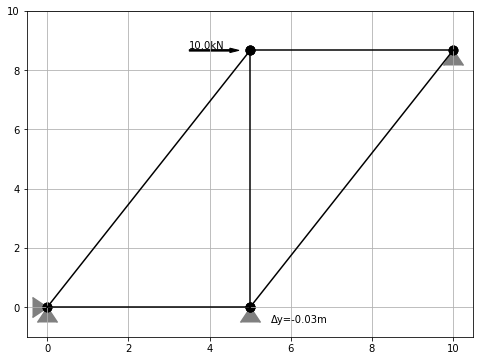

In [14]:
plt.figure(1,figsize=(8,6))
plt.ylim(-1,10)

# Plotagem dos apoios e das forças
for no in nos.index:
    X,Y,RX,RY,Fx,Fy,dx,dy = nos.loc[no]  #percorre os valores de X,Y,RX,RY,Fx,Fy,dx,dy na tabela para cada no do for (1,2,3 e 4)

    # Aplicação dos vínculos (Se RX restrito aplica sobre gl de X)
    if RX == 1:
        plt.scatter(X,Y,400,marker =5,zorder = -2,color ='gray')
    if RY == 1:
        plt.scatter(X,Y,400,marker =6,zorder = -2,color ='gray')

    # Aplicação das forças 
    if Fx >0:
        plt.arrow(X-1.5,Y,1,0,width =0.05,color='k')
        plt.text(X-1.5,Y,'{}kN'.format(Fx/1000),va='bottom')
    if Fx <0:
       plt.arrow(X+1.5,Y,-1,0,width =0.05,color='k')
       plt.text(X+.5,Y,'{}kN'.format(Fx/1000),va='bottom')
    if Fy >0:
        plt.arrow(X,Y-1.5,0,1,width =0.05,color='k')
        plt.text(X,Y,'{}kN'.format(Fy/1000),va='bottom',rotation=90)
    if Fy <0:
       plt.arrow(X,Y+1.5,0,-1,width =0.05,color='k')
       plt.text(X,Y+.5,'{}kN'.format(Fy/1000),ha='right',rotation=90)
        
    # Aplicação dos deslocamentos 
    if dx != 0:
        plt.text(X+0.5,Y-0.5,'Δx={}m'.format(dx),color='black')
    if dy != 0:
        plt.text(X+0.5,Y-0.5,'Δy={}m'.format(dy),color='black')

# Plotagem das barras
for barra in barras.index:
    # Vamos passar os nós para as variáveis N1 e N2
    N1 = barras.loc[barra, 'N1']
    N2 = barras.loc[barra, 'N2']

    # Agora vamos acessar as coordendas de cada um dos nós
    x1, y1 = nos.loc[N1, ['X','Y']]
    x2, y2 = nos.loc[N2, ['X','Y']]
    y = [y1,y2]
    x = [x1,x2]
    
    plt.plot(x,y,'black')
    plt.scatter(x,y, s=80,marker ='o',color ='black')
    plt.grid(True)

`!É uma forma de conferir se os dados foram inseridos de maneira correta, ou seja, a imagem gerada deve ser compatível com a do problema proposto!`

## 4. Comprimento das barras e cos e sen diretores <a name="section_4"></a>

Percorre-se o **DataFrame** de `barras` e a cada passo acessa o **DataFrame** de `nos` para obter suas coordendas. Os valores cálculados serão armazenados em **listas** que serão inseridas no **DataFrame** ao fim do processo.

In [15]:
# Criação de listas vazias para armazenar as variáves
Ls   = []
sens = []
coss = []

for barra in barras.index:
    # Vamos passar os nós para as variáveis N1 e N2. Por exemplo: quando  barra=4 (no for), N1=3 e N2=4
    N1 = barras.loc[barra, 'N1']
    N2 = barras.loc[barra, 'N2']

    # Agora vamos acessar as coordendas de cada um dos nós. Por exemplo: quando  barra=4 (no for), x1=5, y1=8.66, x2=10, y2=8.66
    x1, y1 = nos.loc[N1, ['X','Y']]
    x2, y2 = nos.loc[N2, ['X','Y']]

    # O comprimento da barra é dado pelo teorema de Pitagoras
    Lx = x2 - x1
    Ly = y2 - y1
    L = np.sqrt(Lx**2 + Ly**2)
    
    # Os cossenos diretores são então:
    sen = Ly/L
    cos = Lx/L

    # Inserindo nas listas
    Ls.append(L)
    sens.append(sen)
    coss.append(cos)

# Agora que saimos do loop vamos inserir no DataFrame
barras['L']   = Ls
barras['sen'] = sens
barras['cos'] = coss

# Printando novo DataFrame
barras

,N1,N2,A,E,L,sen,cos
1,1,2,0.010,200000000000,5.000000,0.000000,1.0
2,3,4,0.010,200000000000,5.000000,0.000000,1.0
3,1,3,0.015,200000000000,10.000000,0.866025,0.5
4,2,4,0.015,200000000000,10.000000,0.866025,0.5
5,2,3,0.015,200000000000,8.660254,1.000000,0.0


## 5. Montagem da matriz de rigidez<a name="section_5"></a>
Em posse das propriedades das barras pode-se montar as matrizes de rigidez locais e acoplalas na matriz de rigidez global. Por se tratar de barras de treliça plana cada nó possui 2 graus de liberdade (deslocamentos horizontal e vertical), portanto em treliças planas o números de graus de liberdade sempre será o dobro do número de nós. 

Neste nosso exemplo teremos então 8 graus de liberdade, esses são numerados em função do número do nó conforme as expressões, já mencionadas, a seguir:
$$gdl_h=2n-1$$
$$gdl_v=2n$$

Nossa matriz de rigidez global será então uma matriz de ordem `8x8`, em que os graus de liberdade ímpares correspondem aos deslocamentos horizontais e pares aos verticais.

A matriz de rigidez global é a obtida pela superposição das matrizes de rigidez locais nos respectivos graus de liberdade. Inicialmente a matriz global `K` deve ser pré alocada como uma matriz de zeros.

In [16]:
maxgl = 2*len(nos)
K = np.zeros([maxgl,maxgl])

A alocação é realizada percorrendo todas as barras novamente, cálculando suas matrizes de rigidez local e alocando suas componentes na matriz global.

In [17]:
for barra in barras.index:
    # Vamos importar as propriedades necessárias para construção da matriz local e da matriz de rotação
    L   = barras.loc[barra, 'L']
    sen = barras.loc[barra, 'sen']
    cos = barras.loc[barra, 'cos']
    A   = barras.loc[barra, 'A']
    E   = barras.loc[barra, 'E']
    N1  = barras.loc[barra, 'N1']
    N2  = barras.loc[barra, 'N2']

    # Matriz de rigidez no sistema local 
    Kl = E*A/L*np.array([[ 1, 0,-1, 0],
                         [ 0, 0, 0, 0], 
                         [-1, 0, 1, 0],
                         [ 0, 0, 0, 0]])

    # Matriz de rotação
    Mrot = np.array([[ cos,  sen,    0,   0],
                     [-sen,  cos,    0,   0],
                     [    0,   0,  cos, sen],
                     [    0,   0, -sen, cos]])

    # Rotação da matriz de coordenadas locais para globais, o np.dot é para multiplicação das matrizes
    Klr = np.dot(np.dot(Mrot.T, Kl), Mrot)     

    # Cálculo dos graus de liberdade
    gl1 = 2*N1 - 1
    gl2 = 2*N1 
    gl3 = 2*N2 - 1
    gl4 = 2*N2

    # Aloca a matriz local na matriz global
    # Lembrando as propriedades das listas do Python!
    K[gl1-1:gl2, gl1-1:gl2] += Klr[0:2, 0:2]
    K[gl3-1:gl4, gl1-1:gl2] += Klr[2:4, 0:2]
    K[gl1-1:gl2, gl3-1:gl4] += Klr[0:2, 2:4]
    K[gl3-1:gl4, gl3-1:gl4] += Klr[2:4, 2:4]
    

## 6. Aplicação das condições de contorno<a name="section_6"></a>
Agora, para solução do problema, a matriz de rigidez global é clonada e as restrições de apoio são impostas zerando as respectivas linhas e colunas.

In [18]:
Kcompleta = K.copy()    # Alocando a matriz em outro espaço de memória, pois vou mudar o K,  as será "conservado" em Kcompleta

for no in nos.index:
    RX, RY, dx, dy = nos.loc[no, ['RX','RY','dx','dy']]
    # Se RX restrito aplica sobre gl de X
    if RX == 1:
        gl = 2*no - 1
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição horizontal no nó {:d}.'.format(no))
    
    if RY == 1:
        gl = 2*no
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição vertical no nó {:d}.'.format(no))
            
    # Restrições de deslocamento
    if dx != 0:
        gl = 2*no - 1
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição horizontal devido ao deslocamento no nó {:d}.'.format(no))
    
    if dy != 0:
        gl = 2*no
        K[:,    gl-1] = 0
        K[gl-1,    :] = 0
        K[gl-1, gl-1] = 1
        print('Aplicando restrição vertical devido ao deslocamento no nó {:d}.'.format(no))


Aplicando restrição horizontal no nó 1.
Aplicando restrição vertical no nó 1.
Aplicando restrição vertical no nó 2.
Aplicando restrição vertical devido ao deslocamento no nó 2.
Aplicando restrição vertical no nó 4.


Notar que foi redundante, pois já havia a restrição do apoio, mas caso não tivesse o apoio restringindo, a aplicação da condição de contorno devido ao deslocamento estaria correta!

In [19]:
#print (Kcompleta,'\n')
#print (K)

### 6.1 Montagem do vetor de forças<a name="section_6.1"></a>
Com a matriz global restringida vamos montar o vetor de forças aplicadas. Este vetor tem como dimensão o número de graus de liberdade.

In [20]:
F = np.zeros(maxgl)
Fauxf = np.zeros(maxgl)  #vetor das forças aplicadas
Fauxd = np.zeros(maxgl)  #vetor das forças devido aos deslocamentos sofridos
Fauxdx = np.zeros(maxgl)  #para contar
Fauxdy = np.zeros(maxgl)  #para contar

for no in nos.index:
    RX, RY, FX, FY, dx, dy = nos.loc[no, ['RX','RY','FX','FY','dx','dy']]
    
    gl1 = 2*no - 1
    gl2 = 2*no
    
    if FX != 0:
        Fauxf[gl1-1] = FX 
    if FY != 0:
        Fauxf[gl2-1] = FY
        
    if dx != 0:
        Fauxdx = -Kcompleta[gl1-1, :]*dx
        Fauxdx[gl1-1]=dx
        
    if dy != 0:
        Fauxdy = -Kcompleta[gl2-1, :]*dy
        Fauxdy[gl2-1]=dy
        
    Fauxd =(Fauxdx+Fauxdy)
    
    if RX == 1:
        Fauxd[gl1-1]=0
    if RY == 1:
        Fauxd[gl2-1]=0
    
F=Fauxf+Fauxd
print(F)

[ 0.00000000e+00  0.00000000e+00  3.89711432e+06 -3.00000000e-02
  1.00000000e+04 -1.03923048e+07 -3.89711432e+06  0.00000000e+00]


**`Esta aplicação só serve quando há um deslocamento, pois não foi programado para somar os deslocamento!`**

## 7. Resolução da equação de equilíbrio<a name="section_7"></a>

In [21]:
U = np.linalg.solve(K, F)
print (U)

[ 0.          0.          0.00645617 -0.03       -0.00461628 -0.01713766
 -0.01107245  0.        ]


## 8. Plotagem da treliça deformada<a name="section_8"></a>
Em posse dos valores de deslocamento, é possível realizar a plotagem da treliça deslocada, junto com suas reações de apoio.

**!!!Continuar revisão a partir daqui!!!**

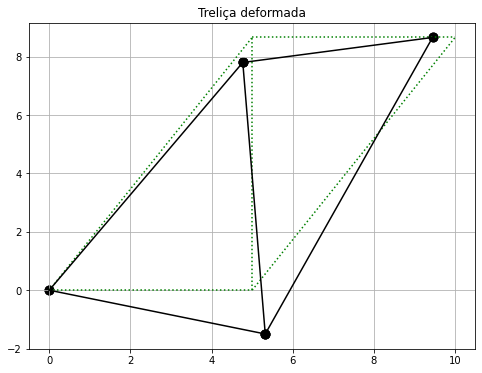

In [28]:
e = 50           #escala da deformação
for barra in barras.index:
    # Vamos passar os nós para as variáveis N1 e N2
    N1 = barras.loc[barra, 'N1']
    N2 = barras.loc[barra, 'N2']

    # Agora vamos acessar as coordendas de cada um dos nós
    x1, y1  = nos.loc[N1, ['X','Y']]
    x2, y2  = nos.loc[N2, ['X','Y']]

    DX = np.array([U[2*N1-2],U[2*N2-2]])
    DY = np.array([U[2*N1-1],U[2*N2-1]])
    y = [y1,y2]
    x = [x1,x2]
    plt.figure(1,figsize=(8,6))
    plt.plot(x,y,'g:')
    plt.plot(x+DX*e,y+DY*e,'black')
    plt.scatter(x+DX*e,y+DY*e, s=80,marker ='o',color ='black')
    plt.grid(True)

_=plt.title('Treliça deformada')

Como comentado na fundamentação teórica, o cálculo das reações de apoio é feito a partir do produto da matriz de rigidez pelos deslocamentos.

In [27]:
R = np.dot(Kcompleta,U)
print(R)

[-1.00000000e+04  4.45564537e+06  0.00000000e+00 -8.92861124e+06
  1.00000000e+04 -1.86264515e-09  6.98491931e-10  4.47296587e+06]


Agora, para a realização da plotagem, é necessário escolher apenas os graus de liberdade que são restritos.

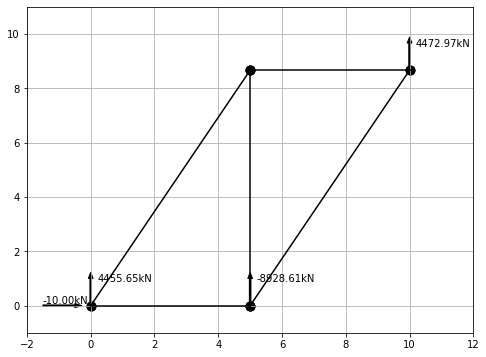

In [30]:
plt.figure(1,figsize=(8,6))
plt.xlim(-2,12)
plt.ylim(-1,11)

# Plotagem dos apoios e das forças
for no in nos.index:
    X,Y,RX,RY= nos.loc[no,['X','Y','RX','RY']]

    gl1 = 2*no - 1
    gl2 = 2*no 
    Fx = R[gl1-1]
    Fy = R[gl2-1]

    # Se RX restrito aplica sobre gl de X
    if RX == 1:
        plt.arrow(X-1.5,Y,1,0,width =0.05,color='k')
        plt.text(X-1.5,Y,'{:.2f}kN'.format(Fx/1000),va='bottom')
    if RY == 1:
        plt.arrow(X,Y,0,1,width =0.05,color='k')
        plt.text(X+0.2,Y+0.8,'{:.2f}kN'.format(Fy/1000),va='bottom')

# Plotagem das barras
for barra in barras.index:
    # Vamos passar os nós para as variáveis N1 e N2
    N1 = barras.loc[barra, 'N1']
    N2 = barras.loc[barra, 'N2']

    # Agora vamos acessar as coordendas de cada um dos nós
    x1, y1 = nos.loc[N1, ['X','Y']]
    x2, y2 = nos.loc[N2, ['X','Y']]
    y = [y1,y2]
    x = [x1,x2]
    
    plt.plot(x,y,'black')
    plt.scatter(x,y, s=80,marker ='o',color ='black')
    plt.grid(True)

## 9. Determinação dos esforços<a name="section_9"></a>
Para finalizar a análise, é interessante o cálculo dos esforços atuantes em cada elemento, para isso, realiza-se o script abaixo:

In [31]:
Esf = []

for barra in barras.index:
    # Vamos importar as propriedades necessárias para construção da matriz local e da matriz de rotação
    L   = barras.loc[barra, 'L']
    sen = barras.loc[barra, 'sen']
    cos = barras.loc[barra, 'cos']
    A   = barras.loc[barra, 'A']
    E   = barras.loc[barra, 'E']
    N1  = barras.loc[barra, 'N1']
    N2  = barras.loc[barra, 'N2']

    # Matriz de rigidez no sistema local 
    Kl = E*A/L*np.array([[ 1, 0,-1, 0],
                         [ 0, 0, 0, 0], 
                         [-1, 0, 1, 0],
                         [ 0, 0, 0, 0]])

    # Matriz de rotação
    Mrot = np.array([[ cos,  sen,    0,   0],
                     [-sen,  cos,    0,   0],
                     [    0,   0,  cos, sen],
                     [    0,   0, -sen, cos]])
    # Recebendo os deslocamentos referentes ao elemento em análise
    Ul = np.zeros(4)
    Ul[0] = U[2*N1-2]
    Ul[1] = U[2*N1-1]
    Ul[2] = U[2*N2-2]
    Ul[3] = U[2*N2-1]

    # Realizando o equilíbrio local

    F = np.dot(Kl,np.dot(Mrot,Ul))

    # Salvando o terceiro valor do vetor de forças por convenção de sinais.
    Esf.append(F[2])

Agora, vamos plotar os esforços, sinalizando as barras comprimidas pela cor azul e as tracionadas pela cor vermelha.

<ipython-input-33-907f7762370e>:8: RuntimeWarning: divide by zero encountered in double_scalars
  tg  = sen/cos


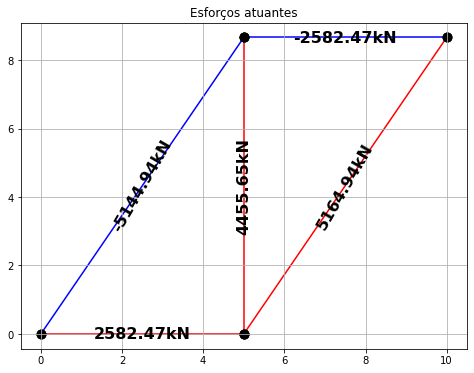

In [33]:
for barra in barras.index:
    # Vamos passar os nós para as variáveis N1 e N2
    N1 = barras.loc[barra, 'N1']
    N2 = barras.loc[barra, 'N2']
    ax = Esf[barra-1]
    cos = barras.loc[barra, 'cos']
    sen = barras.loc[barra, 'sen']
    tg  = sen/cos
    # Agora vamos acessar as coordendas de cada um dos nós
    x1, y1  = nos.loc[N1, ['X','Y']]
    x2, y2  = nos.loc[N2, ['X','Y']]
    y = [y1,y2]
    x = [x1,x2]

    plt.figure(1,figsize=(8,6))
    if ax>0:
        cor = 'r'
    elif ax == 0:
        cor = 'k'
    else:
        cor = 'b'
    plt.plot(x,y,cor,zorder = -1)

    plt.text(np.mean(x),np.mean(y),'{:.2f}kN'.format(ax/1000),rotation =180*np.arctan(tg)/np.pi,
            horizontalalignment='center',
            verticalalignment='center',
            size = 16,
            weight = 'bold')

    plt.scatter(x,y, s=80,marker ='o',color ='black')
    

_=plt.title('Esforços atuantes')
plt.grid(True)